### Prematurity classification on the dHCP database.

In [12]:
import os 
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [3]:
region = "STs_right"

labels_path = "/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/preterm_labels.csv"
base_path = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation"
    

region_path = os.path.join(base_path, region)
    
# Trouver le nom du dossier unique automatiquement
subdirs = [d for d in os.listdir(region_path) if os.path.isdir(os.path.join(region_path, d))]
if len(subdirs) != 1:
    raise RuntimeError(f"Il y a {len(subdirs)} sous-dossiers dans {region_path}, impossible de choisir automatiquement car il y a plusieurs modèles enregistrés par région.")
model_folder = subdirs[0]

# Construire les chemins complets
embedding_path = os.path.join(region_path, model_folder, "dHCP_random_embeddings", "full_embeddings.csv")

In [ ]:

# Load embeddings and labels
labels = pd.read_csv(labels_path)
embeddings = pd.read_csv(embedding_path, index_col=0)
embeddings= embeddings.loc[embeddings.index.isin(labels['Subject'])]

# Visu labels
labels=labels["birth_age"]


print("Shape embeddings", embeddings.shape)
print("Shape labels", labels.shape)

# Scaling
scaler = StandardScaler().fit(embeddings)
Xs = scaler.transform(embeddings)

results = {}
for T in [28, 32, 37]:
    y = (labels < T).astype(int).values
    
    # Train linear SVC
    clf = SVC(kernel='linear', C=0.01, class_weight='balanced')
    clf.fit(Xs, y)
    scores = clf.decision_function(Xs)

    # AUC
    auc = roc_auc_score(y, scores)

    # Permutation 
    auc_null = []
    for _ in range(200):
        y_perm = np.random.permutation(y)
        clf.fit(Xs, y_perm)
        auc_null.append(roc_auc_score(y_perm, clf.decision_function(Xs)))
    p_value = np.mean(np.array(auc_null) >= auc)
    ci95 = np.percentile(auc_null, 95)

    results[T] = {'AUC': auc, 'p_value': p_value, 'null95': ci95}

Shape embeddings (374, 32)
Shape labels (374,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 

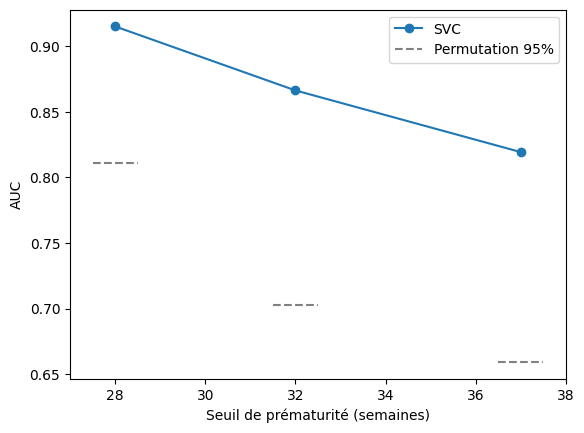

In [14]:
# Plots

seuils = list(results.keys())
aucs   = [results[T]['AUC'] for T in seuils]
ci95s  = [results[T]['null95'] for T in seuils]

plt.plot(seuils, aucs, marker='o', label='SVC')
plt.hlines(ci95s, [s-0.5 for s in seuils], [s+0.5 for s in seuils],
           linestyles='dashed', colors='gray', label='Permutation 95%')
plt.xlabel('Seuil de prématurité (semaines)')
plt.ylabel('AUC')
plt.legend()
plt.title(f"Résultats de classification binaire pour différents seuil ")
plt.show()
